In [1]:
import json
from sklearn import tree
from tqdm import tqdm
from sklearn.model_selection import train_test_split


In [2]:
# load all prediction results
with open('./tmp/geoloc_all_pred.json') as ifile:
    all_pred = json.load(ifile)

In [3]:
# get all used positive semantic pairs
used_semantic_pairs = []
for doc in all_pred:
    for sent in tqdm(doc):
        if sent['max_sim_pairs']:
            used_semantic_pairs.append(tuple(sent['max_sim_pairs'][1]))


100%|██████████| 13/13 [00:00<00:00, 125059.52it/s]


In [4]:
used_semantic_pairs = list(set(used_semantic_pairs))


In [57]:
# process data for tree classifier input
def data_process(datas):
    X = []
    y = []

    for doc in datas:
        for sent in doc:
            if sent['max_sim_pairs']:
                most_sim_pos_pair = tuple(sent['max_sim_pairs'][1])
                pos_pair_idx = used_semantic_pairs.index(most_sim_pos_pair)
#                 X.append([sent['pos_score'], pos_pair_idx])
                X.append([pos_pair_idx, sent['pos_score']])
                y.append(sent['label'])
            else:
                X.append([-1, -1])
                y.append(sent['label'])
    return X, y

In [58]:
train, test = train_test_split(all_pred, test_size=0.9, random_state=1)

In [71]:
len(train)

13

In [59]:
X_train, y_train = data_process(train)
X_test, y_test = data_process(test)

In [60]:
clf = tree.DecisionTreeClassifier()

In [61]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [62]:
tree_preds = clf.predict(X_test)

In [63]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [64]:
print('sent acc:', accuracy_score(y_test, tree_preds))
print('sent prec', precision_score(y_test, tree_preds))
print('sent recall', recall_score(y_test, tree_preds))
print('sent f1', f1_score(y_test, tree_preds))

sent acc: 0.9656406585540444
sent prec 0.8705882352941177
sent recall 0.6666666666666666
sent f1 0.7551020408163265


In [65]:
# document level
test_doc_pred = []
test_doc_truth = []
for doc in test:
    p_X, p_y = data_process([doc])
    _preds = clf.predict(p_X)
    if 1 in p_y:
        test_doc_truth.append(1)
    else:
        test_doc_truth.append(0)
    if 1 in _preds:
        test_doc_pred.append(1)
    else:
        test_doc_pred.append(0)

In [66]:
print('doc acc:', accuracy_score(test_doc_truth, test_doc_pred))
print('doc prec', precision_score(test_doc_truth, test_doc_pred))
print('doc recall', recall_score(test_doc_truth, test_doc_pred))
print('doc f1', f1_score(test_doc_truth, test_doc_pred))

doc acc: 0.84
doc prec 0.8846153846153846
doc recall 0.7666666666666667
doc f1 0.8214285714285715


In [67]:
import graphviz 

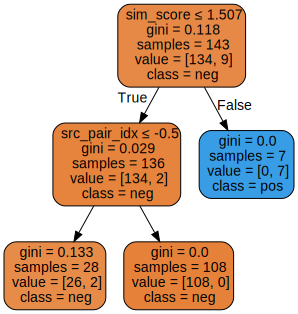

In [70]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                     feature_names=['src_pair_idx', 'sim_score'], 
                     class_names=['neg', 'pos'],
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

In [69]:
p_X

[[18, 0.6240569800138474],
 [16, 1.2758654356002808],
 [-1, -1],
 [8, 1.1258774995803833],
 [7, 0.7183494567871094],
 [3, 0.5469956398010254],
 [15, 0.21502156555652618],
 [16, 0.8571047186851501]]

In [46]:
p_y

[0, 0, 0, 1, 0, 0, 0, 0]